In [65]:
import MDAnalysis as mda
atomistic_system = mda.Universe
from modules.distances import *
from modules.dssp import dssp
from modules.input import res_list, show_fasta
from typing import Tuple
%reload_ext autoreload
%autoreload 2
import input
import MDAnalysis.analysis.align as align

In [66]:
atomistic_system, reference_structure, energy_like_terms, is_aligned = input.read_files()
is_aligned = input.align_traj(is_aligned)

Aligned file found, reading this instead
Trajectory allready aligned, delete md1000ns_center_po_aligned.xtc to rerun alignement


In [67]:
show_fasta(atomistic_system)

----5----10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95---100--105--110--115--120--125--130--135--140--145--150--155--160--165--170--
TTAPEAPSVNDTEVGSKKVSGKGHEVGNTVTVTFPDGKTATSKVDEKGNWTVDVPEGTELKVGNEITATETDMSGNKSESGKGKVTDTTAPEAPSVNDTEVGSKKVSGKGHEVGNTVTVTFPDGKTATSKVDEKGNWTVDVPEGTELKVGNEITATETDMSGNKSESGKGKVTD
--------E--E-----EEEEE------EEEEEE---EEEEEEE----EEEEE-----------EEEEEEE-----E---EEEEE---------EE-EE-----EEEEE------EEEEEE---EEEEEEE----EEEEE-----------EEEEEEE-----E---EEEEE--


In [68]:
#Select 2 vectors as 4 list of residues to get 4 center of mass
list_resA = [6,18,29,39,49,66]
list_resB = [12,22,33,44,53,72]
list_resC = [x+87 for x in list_resA]
list_resD = [x+87 for x in list_resB] 

def list_to_selection(res_list: list):
    sele = ""
    for resid in res_list:
        sele = sele + f"resid {resid}"
        if resid != res_list[-1]:
            sele = sele + " or "
    return sele

seleA = list_to_selection(list_resA)
seleB = list_to_selection(list_resB)
seleC = list_to_selection(list_resC)
seleD = list_to_selection(list_resD)

def get_vector_CoM(atomistic_system, seleA, seleB):
    CoM_A = atomistic_system.select_atoms(seleA).center_of_mass()
    CoM_B = atomistic_system.select_atoms(seleB).center_of_mass()
    vector = np.array([CoM_B[0] - CoM_A[0], CoM_B[1] - CoM_A[1], CoM_B[2] - CoM_A[2]])
    return vector

In [69]:
#Print a pymol script 
CoM_A = atomistic_system.select_atoms(seleA).center_of_mass()
CoM_B = atomistic_system.select_atoms(seleB).center_of_mass()
CoM_C = atomistic_system.select_atoms(seleC).center_of_mass()
CoM_D = atomistic_system.select_atoms(seleD).center_of_mass()
print(f"pseudoatom CoM_A, pos = [{CoM_A[0]}, {CoM_A[1]}, {CoM_A[2]}]")
print(f"pseudoatom CoM_B, pos = [{CoM_B[0]}, {CoM_B[1]}, {CoM_B[2]}]")
print("distance /CoM_A, /CoM_B")
print(f"pseudoatom CoM_C, pos = [{CoM_C[0]}, {CoM_C[1]}, {CoM_C[2]}]")
print(f"pseudoatom CoM_D, pos = [{CoM_D[0]}, {CoM_D[1]}, {CoM_D[2]}]")
print("distance /CoM_C, /CoM_D")

pseudoatom CoM_A, pos = [92.02614487586064, 78.51492165642628, 22.64364306571327]
pseudoatom CoM_B, pos = [93.7925921243991, 78.98763809383404, 24.234793965702398]
distance /CoM_A, /CoM_B
pseudoatom CoM_C, pos = [55.03745788809276, 72.6302535731171, 42.877541945847675]
pseudoatom CoM_D, pos = [55.39315525020797, 73.76112881978516, 40.96125065919093]
distance /CoM_C, /CoM_D


In [70]:
# vetor from PCA
sele_residues_vectorA = "(resid 10 to 80) and name CA"
sele_residues_vectorB = "(resid 97 to 167) and name CA"

def get_vector_PCA(atomistic_system, sele):
    CAs = atomistic_system.select_atoms(sele).positions
    mean_point = np.mean(CAs, axis=0)
    cov_matrix = np.cov((CAs - mean_point).T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    dominating_direction = eigenvectors[:, np.argmax(eigenvalues)]
    return dominating_direction

In [79]:
reference = atomistic_system.select_atoms(sele_residues_vectorA)
aligner = align.AlignTraj(atomistic_system, reference, 
                                select=sele_residues_vectorA,
                                in_memory=False, 
                                filename=input.sim_path + input.trajectory_file_name.split(".")[0] + "_vector_aligned.xtc")
aligner.run(verbose=True)


  0%|          | 0/100001 [00:00<?, ?it/s]

In [ ]:
atomistic_system_aligned = mda.Universe(f"{input.sim_path}{input.coordinate_file_name}", f"{input.sim_path}{input.trajectory_file_name.split('.')[0]}_vector_aligned.xtc")

1


In [73]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [83]:
angles = []

for ts in atomistic_system.trajectory:
    if atomistic_system.trajectory.time > 500000:
        break
    vector1 = get_vector_CoM(atomistic_system,seleA,seleB)
    vector2 = get_vector_CoM(atomistic_system,seleC,seleD)
    #vector1 = get_vector_PCA(atomistic_system,sele_residues_vectorA)
    #vector2 = get_vector_PCA(atomistic_system,sele_residues_vectorB)
    angle_rad = angle_between(vector1, vector2)


    angles.append([atomistic_system.trajectory.time, angle_rad])


angles = np.array(angles)

In [84]:
# Plot the polar plot
from scipy.stats import gaussian_kde

polar_angles = np.array(angles.T[1])
rounded_angles = np.round(polar_angles, decimals=2)
unique_rounded_angles, counts = np.unique(rounded_angles, return_counts=True)
marker_sizes = counts * 10

pdf = gaussian_kde(polar_angles)(polar_angles)


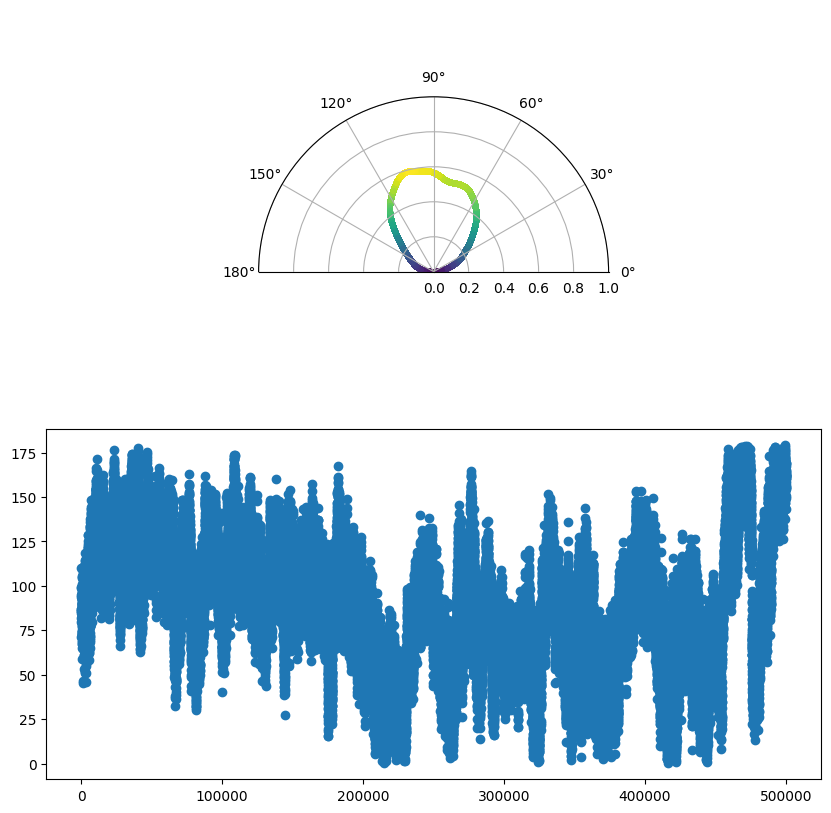

In [104]:
import matplotlib.gridspec as gridspec
fig = plt.figure()
spec = gridspec.GridSpec(2,1,height_ratios=[0.5,0.5] ,figure=fig)
fig.set(figwidth=12)
fig.set(figwidth= 10, figheight=10)

pol = fig.add_subplot(spec[0,0], projection = 'polar')
pol.set_thetamin(0)
pol.set_thetamax(180)
pol.scatter(polar_angles, pdf, c=pdf, s=10)
pol.set_rmax(1)  # Set the maximum radius of the plot

time = fig.add_subplot(spec[1,0])
time.scatter( angles.T[0], polar_angles*180/3.14)

In [77]:
# Plot the polar plot
timepoint = 21123

polar_angles = np.array(angles.T[2])

fig = plt.figure()
fig.set(figwidth= 10, figheight=10)
ax = plt.subplot(111, projection='polar')
ax.plot(polar_angles[timepoint], 1,  marker='o', markersize=10, color='r', linestyle='None')
print(polar_angles[timepoint]*180/3.14)
ax.set_rmax(1.5)  # Set the maximum radius of the plot



IndexError: index 2 is out of bounds for axis 0 with size 2